In [104]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, UpSampling2D, Input, Concatenate, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Set NumPy random seed for reproducibility
np.random.seed(42)

# Set TensorFlow random seed for reproducibility
tf.random.set_seed(42)

# Define image size for resizing input images and masks
WIDTH = 672
HEIGHT = 504

# Define number of epochs for training
EPOCHS = 5

# Define batch size
BATCH = 1

# Define learning rate for the optimizer
LR = 1e-4

# Define output path for saving training results and model
PATH = "/root/61541v001/V-01"

# Define label colors
colors = [
    (0, 0, 0), (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), 
    (128, 0, 128), (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), 
    (64, 128, 0), (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), 
    (192, 128, 128), (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), 
    (0, 64, 128), (128, 64, 12)
]
NUM_CLASSES = len(colors)

In [105]:
# Load dataset
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(PATH, "image/*")))
    masks = sorted(glob(os.path.join(PATH, "label/*")))
    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

# Read and preprocess image
def read_image(path):
    if isinstance(path, bytes):
        path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (WIDTH, HEIGHT))
    x = x / 255.0
    return x.astype(np.float32)

# Read and preprocess mask
def read_mask(path):
    if isinstance(path, bytes):
        path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (WIDTH, HEIGHT))
    x = x / 255.0
    x = np.round(x * (NUM_CLASSES - 1)).astype(np.uint8)
    x = tf.keras.utils.to_categorical(x, num_classes=NUM_CLASSES)
    return x.astype(np.float32)

# Parse function for TensorFlow dataset
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([HEIGHT, WIDTH, 3])
    y.set_shape([HEIGHT, WIDTH, NUM_CLASSES])
    return x, y

# Create TensorFlow dataset
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

# Parse mask for visualization
def mask_parse(mask):
    mask = np.argmax(mask, axis=-1)  # Convert one-hot encoded mask to single-channel class mask
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)  # Create an empty color mask
    for i, color in enumerate(colors):
        rgb_mask[mask == i] = color  # Map class values to predefined colors
    return rgb_mask

# Build the model
def build_model():
    inputs = Input(shape=(HEIGHT, WIDTH, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    f = [16, 32, 48, 64]
    x = encoder_output

    for i in range(1, len(skip_connection_names) + 1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        height_diff = K.int_shape(x)[1] - K.int_shape(x_skip)[1]
        width_diff = K.int_shape(x)[2] - K.int_shape(x_skip)[2]
        if height_diff != 0 or width_diff != 0:
            x = Cropping2D(((height_diff // 2, height_diff - height_diff // 2),
                            (width_diff // 2, width_diff - width_diff // 2)))(x)
        x = Concatenate()([x, x_skip])
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(NUM_CLASSES, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)
    model = Model(inputs, x)
    return model

In [106]:
# Load dataset
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)
print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  595
Validation data:  74
Testing data:  74


In [107]:
# Define custom metrics
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f))

def iou(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return intersection / union

In [108]:
# Create and compile the model
model = build_model()
model.summary()
loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Nadam(LR)
metrics = ['accuracy']
model.compile(loss=loss, optimizer=opt, metrics=['accuracy', dice_coefficient, iou])

/tmp/ipykernel_5823/2080664991.py:68: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 504, 672,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 252, 336,  │        432 │ input_image[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 252, 336,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 252, 336,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 252, 336,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 252, 336,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 252, 336,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 252, 336,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 252, 336,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 252, 336,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 252, 336,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 252, 336,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 253, 337,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 126, 168,  │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 126, 168,  │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 126, 168,  │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 126, 168,  │        384 │ block_1_depthwis

 Total params: 416,566 (1.59 MB)

 Trainable params: 409,382 (1.56 MB)

 Non-trainable params: 7,184 (28.06 KB)

In [2]:
# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

train_steps = len(train_x) // BATCH
valid_steps = len(valid_x) // BATCH
if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

# Train the model and record history
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

def calculate_iou(y_true, y_pred):
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score


NameError: name 'ReduceLROnPlateau' is not defined

In [110]:
# Evaluate the model
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = (len(test_x) // BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
results = model.evaluate(test_dataset, steps=test_steps)

# Get metric names
metrics_names = model.metrics_names

# Print evaluation results
for name, value in zip(metrics_names, results):
    print(f"{name}: {value:.4f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8729 - dice_coefficient: 0.7590 - iou: 0.6155 - loss: 0.4694
loss: 0.4704
compile_metrics: 0.8720


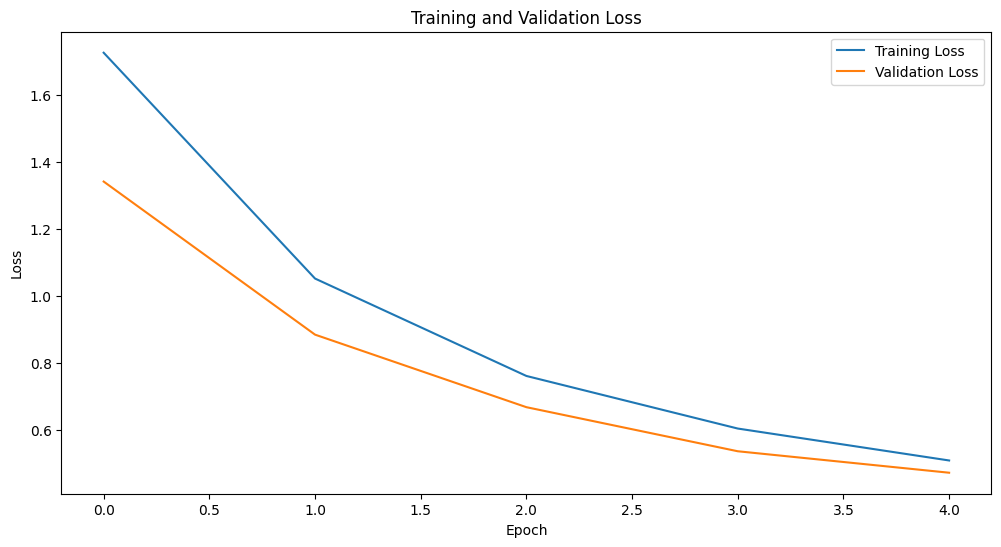

In [111]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

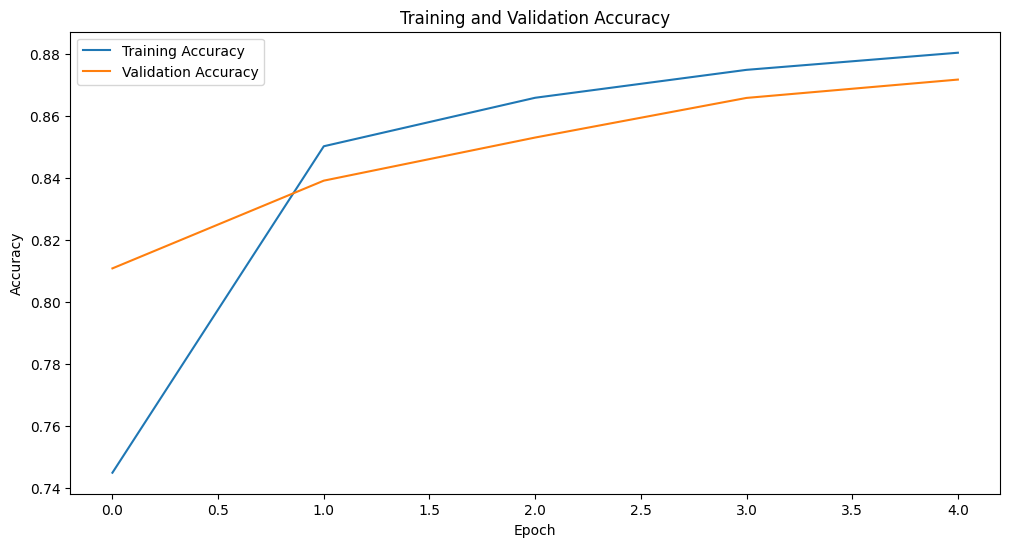

In [112]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

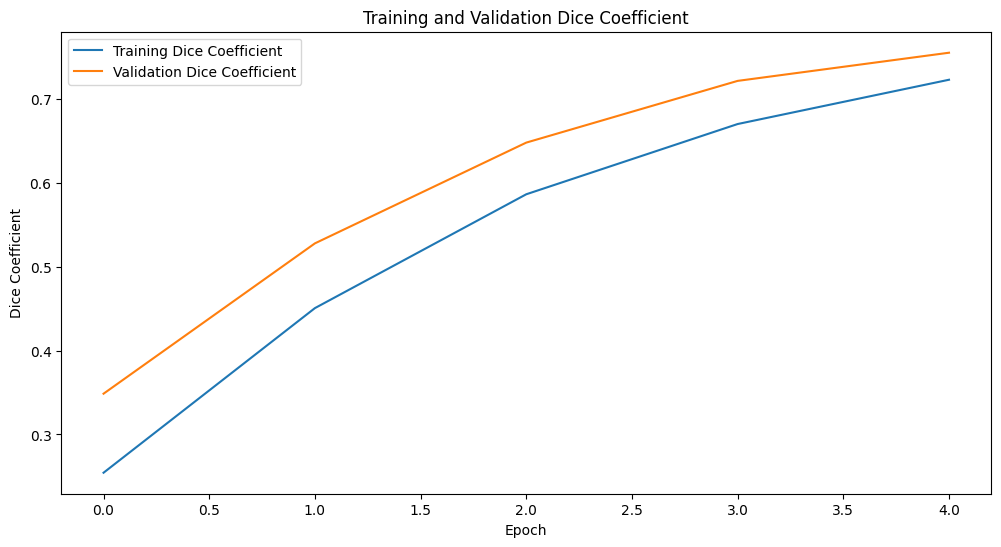

In [113]:
# Plot training and validation Dice coefficient
plt.figure(figsize=(12, 6))
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.show()

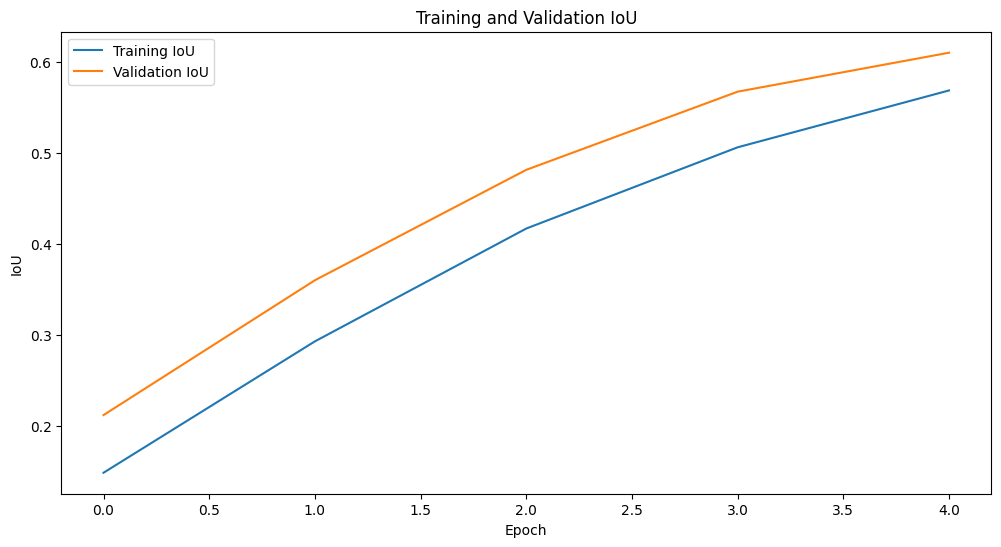

In [114]:
# Plot training and validation IoU
plt.figure(figsize=(12, 6))
plt.plot(history.history['iou'], label='Training IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.legend()
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.show()

In [1]:
# Visualize prediction results
for i, (x_path, y_path) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x_path)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_original = read_mask(y_path)  # Directly read the mask
    
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3)) * 255
    
    all_images = [
        x * 255, white_line,
        mask_parse(y_original), white_line,  # Parse and display the original mask
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1).astype(np.uint8)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    plt.show()

iou_scores = []

for x_path, y_path in zip(test_x, test_y):
    x = read_image(x_path)
    y_true = read_mask(y_path)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]

    iou = calculate_iou(y_true, y_pred)
    iou_scores.append(iou)

# 计算平均交并比
miou = np.mean(iou_scores)
print("Mean IoU:", miou)


NameError: name 'test_x' is not defined